In [1]:
# !pip install vaderSentiment
# !pip install textstat
# !pip install wordcloud

In [2]:
import pandas as panda
import time
import vaderSentiment
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

ModuleNotFoundError: No module named 'vaderSentiment'

Loading the Data

In [3]:
dataset = panda.read_csv("HateSpeechData.csv")
dataset.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


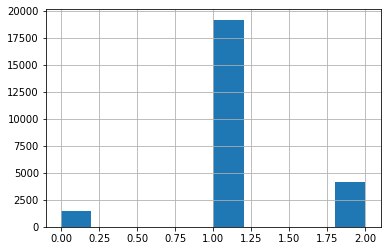

In [4]:
dataset['class'].hist()

In [ ]:
##The above histogram shows that most of the tweets are considered to be offensive words by the CF coders.

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

## Preprocessing of the tweets

In [5]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # removal of capitalization
    tweet_lower = punc_remove.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
dataset

NameError: name 'nltk' is not defined

## Visualizations

In [ ]:
# visualizing which of the word is most commonly used in the twitter dataset

import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 2]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Feature Generation

In [ ]:
# Bigram Features

bigram_vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.75, min_df=1, max_features=10000)
# bigram feature matrix
bigram = bigram_vectorizer.fit_transform(processed_tweets).toarray()
bigram

In [ ]:
#TF-IDF Features

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

## Building Models using Logistic Regression

In [6]:
# Using Bigram Features
X = panda.DataFrame(bigram)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


model = LogisticRegression(class_weight='balanced',penalty="l2", C=0.01).fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))


NameError: name 'bigram' is not defined

In [ ]:
# Running the model Using TFIDF without additional features

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


model = LogisticRegression(penalty='l2',  max_iter=1000).fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

# test cells begin

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
sia = SIA()

sent_dict = sia.polarity_scores("You are such a piece of shit man!")
sent_dict
# count_tags("Hello there https://google.com @google_USA is a total #wasteOfTime")
# sentiment_analysis_array(tweet[:5])
# tfidf_a

In [ ]:
a = np.arange(18, 36, 2).reshape(3, 3).astype('int')
b = np.arange(1, 10, 1).reshape(3, 3).astype('int')
np.concatenate((a, b), axis=1)

# test cells end

In [ ]:
# Sentiment Analysis
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

In [ ]:
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
print(f"modelling_features.shape: {modelling_features.shape}\ntfidf.shape: {tfidf_a.shape}\nfinal_features.shape: {final_features.shape}")

In [ ]:
# Running the model Using TFIDF with some features from sentiment analysis

X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

model_acc = LogisticRegression(max_iter=1000).fit(X_train_bow,y_train)
y_preds = model_acc.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

In [ ]:
def additional_features(tweet): 
    
    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(tweet.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)


In [ ]:
###################################

textstat.syllable_count('tweet')
([len(w) for w in 'Hello there man'])
# len('Hello there man')
###################################
fFeatures.shape

In [ ]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_enhanced.shape

In [ ]:
#tracking time
start = time.time()

# Running the model Using TFIDF with additional features from sentiment analysis

X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

model = LogisticRegression(max_iter=10000, verbose=3).fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

end=time.time()

In [ ]:
print(f"time taken: {(end-start)/60}min")

In [ ]:
X_test_features.shape

In [ ]:
#Confusion Matrix for TFIDF with additional features 
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

# new text classification

In [3]:
def classify(tweet=''):
    if(tweet==''):
        new_tweet = str(input("Enter a sentence/tweet: \n"))
    else:
        new_tweet = tweet
    nt_df = panda.DataFrame({'tweet': new_tweet}, index=range(1))
    new_tweet = preprocess(nt_df.tweet)[0]
    nt_final_features = np.array(sentiment_analysis(new_tweet)).reshape(1, -1)
    nt_tfidf = tfidf_vectorizer.transform([new_tweet]).toarray()
    nt_modelling_features = np.concatenate([nt_tfidf, nt_final_features], axis=1)
#     print(f"{nt_tfidf.shape}\n{nt_final_features.shape}\n{nt_modelling_features.shape}")
    nt_pred = model_acc.predict(nt_modelling_features)[0]
#     return nt_pred[0]
    nt_class = ''
    if(nt_pred==0): nt_class="Extreme racial/offensive hate"
    elif(nt_pred==1): nt_class="Non-Extreme hate speech"
    else: nt_class="Non-hateful speech"
    print(f"\n\npredicted class: {nt_pred}\nThe model classifies the given text as: \"{nt_class}\"")

In [ ]:
classify("")